# Featurize processed data

In [1]:
repo_path = "/Users/johnzhou/research/decision-making"

## Import packages

In [2]:
import sys
sys.path.append(repo_path)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from sklearn.cluster import KMeans
import torch

from src.data.experiment_data import ExperimentData
from src.features.build_features import normalize_features, remove_invalid_fits
from src.models.sigmoidnet import SigmoidNet
from src.models.train import train

/Users/johnzhou/anaconda3/envs/ssm/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
expt_name = "new_run"
bigboy = ExperimentData(expt_name, repo_path)
# print(bigboy.sigmoid_parameters.shape, bigboy.foraging_efficiency.shape, bigboy.choice_blocks.shape)
valid_idxs = bigboy.get_valid_idxs(boundary=50000)
a = bigboy.build_modeling_feats(include_feff=False, include_block=False, idxs=valid_idxs)
b = bigboy.build_modeling_labels(idxs=valid_idxs)

print(a.shape)

24945
(49945, 1, 3)
(49945, 1)
(49945, 1, 3)


Sigmoid fitting with MSE loss seems to be empirically more sensitive.

In [5]:
config = OmegaConf.create({
    "name": expt_name,
    "random_seed": 4995,
    "model": {
        "in_features": 3,
        "linear_layers": [32, 8, 4],
        "use_batch_norm": False
    },
    "learning_rate": 1e-4,
    "data": {
        "feature_path": f"{bigboy.data_path}/modeling_features.npy",
        "label_path": f"{bigboy.data_path}/modeling_labels.npy",
        "train_proportion": 0.8,
        "train_batch_size": 128,
        "val_batch_size": 128
    },
    "trainer": {
        "gpus": 0,
        "max_epochs": 1000
    },

})

OmegaConf.save(config=config, f=f"{repo_path}/configs/model_configs/sigmoidnet_train.yaml")

In [7]:
%reload_ext tensorboard
%tensorboard --logdir=$bigboy.data_path/lightning_logs

In [6]:
system, trainer = train(
    SigmoidNet,
    OmegaConf.to_container(config),
    experiment_dir=bigboy.data_path,
    checkpoint_name="model")

Global seed set to 4995


LinearEmbedder(
  (layers): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.05)
    (2): Linear(in_features=32, out_features=8, bias=True)
    (3): LeakyReLU(negative_slope=0.05)
    (4): Linear(in_features=8, out_features=4, bias=True)
    (5): LeakyReLU(negative_slope=0.05)
    (6): Linear(in_features=4, out_features=2, bias=True)
  )
)


/Users/johnzhou/anaconda3/envs/ssm/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /Users/johnzhou/research/decision-making/data/processed/new_run/new_run/lightning_logs

  | Name  | Type           | Params
-----------------------------------------
0 | loss  | SupConLoss     | 0     
1 | model | LinearEmbedder | 438   
-----------------------------------------
438       Trainable params
0         Non-trainable params
438       Total params
0.002     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|                                 | 0/2 [00:00<?, ?it/s]

/Users/johnzhou/anaconda3/envs/ssm/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/Users/johnzhou/anaconda3/envs/ssm/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  77%|████████████████     | 300/392 [00:01<00:00, 234.44it/s, loss=4.84, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|█████| 392/392 [00:01<00:00, 244.13it/s, loss=4.75, v_num=0, val_loss=4.840]
Epoch 1:  77%|▊| 300/392 [00:01<00:00, 221.86it/s, loss=4.84, v_num=0, val_loss=4.840, tra
Validation: 0it [00:00, ?it/s]
Validation:   0%|                                                  | 0/79 [00:00<?, ?it/s]
Epoch 1:  82%|▊| 320/392 [00:01<00:00, 218.06it/s, loss=4.84, v_num=0, val_loss=4.840, tra
Epoch 1:  87%|▊| 340/392 [00:01<00:00, 222.87it/s, loss=4.84, v_num=0, val_loss=4.840, tra
Epoch 1:  92%|▉| 360/392 [00:01<00:00, 224.89it/s, loss=4.84, v_num=0, val_loss=4.840, tra
Epoch 1:  97%|▉| 380/392 [00:01<00:00, 228.23it/s, loss=4.84, v_num=0, val_loss=4.840, tra
Epoch 1: 100%|█| 392/392 [00:01<00:00, 227.85it/s, loss=4.75, v_num=0, val_loss=4.840, tra
Epoch 2:  77%|▊| 300/392 [00:01<00:00, 217.46it/s, loss=4.81, v_num=0, val_loss=4.840, tra
Validation: 0it [00:00, ?it/

Epoch 11:  97%|▉| 380/392 [00:01<00:00, 239.27it/s, loss=4.54, v_num=0, val_loss=4.560, tr
Epoch 11: 100%|█| 392/392 [00:01<00:00, 240.93it/s, loss=4.47, v_num=0, val_loss=4.540, tr
Epoch 12:  77%|▊| 300/392 [00:01<00:00, 228.48it/s, loss=4.53, v_num=0, val_loss=4.540, tr
Validation: 0it [00:00, ?it/s]
Validation:   0%|                                                  | 0/79 [00:00<?, ?it/s]
Epoch 12:  82%|▊| 320/392 [00:01<00:00, 227.17it/s, loss=4.53, v_num=0, val_loss=4.540, tr
Epoch 12:  87%|▊| 340/392 [00:01<00:00, 231.88it/s, loss=4.53, v_num=0, val_loss=4.540, tr
Epoch 12:  92%|▉| 360/392 [00:01<00:00, 236.34it/s, loss=4.53, v_num=0, val_loss=4.540, tr
Epoch 12:  97%|▉| 380/392 [00:01<00:00, 240.85it/s, loss=4.53, v_num=0, val_loss=4.540, tr
Epoch 12: 100%|█| 392/392 [00:01<00:00, 243.19it/s, loss=4.46, v_num=0, val_loss=4.530, tr
Epoch 13:  77%|▊| 300/392 [00:01<00:00, 225.57it/s, loss=4.52, v_num=0, val_loss=4.530, tr
Validation: 0it [00:00, ?it/s]
Validation:   0%|           

Epoch 23:  87%|▊| 340/392 [00:01<00:00, 229.24it/s, loss=4.48, v_num=0, val_loss=4.500, tr
Epoch 23:  92%|▉| 360/392 [00:01<00:00, 234.88it/s, loss=4.48, v_num=0, val_loss=4.500, tr
Epoch 23:  97%|▉| 380/392 [00:01<00:00, 239.73it/s, loss=4.48, v_num=0, val_loss=4.500, tr
Epoch 23: 100%|█| 392/392 [00:01<00:00, 242.07it/s, loss=4.43, v_num=0, val_loss=4.500, tr
Epoch 24:  77%|▊| 300/392 [00:01<00:00, 227.51it/s, loss=4.48, v_num=0, val_loss=4.500, tr
Validation: 0it [00:00, ?it/s]
Validation:   0%|                                                  | 0/79 [00:00<?, ?it/s]
Epoch 24:  82%|▊| 320/392 [00:01<00:00, 226.37it/s, loss=4.48, v_num=0, val_loss=4.500, tr
Epoch 24:  87%|▊| 340/392 [00:01<00:00, 231.37it/s, loss=4.48, v_num=0, val_loss=4.500, tr
Epoch 24:  92%|▉| 360/392 [00:01<00:00, 236.60it/s, loss=4.48, v_num=0, val_loss=4.500, tr
Epoch 24:  97%|▉| 380/392 [00:01<00:00, 241.31it/s, loss=4.48, v_num=0, val_loss=4.500, tr
Epoch 24: 100%|█| 392/392 [00:01<00:00, 243.36it/s, loss=4.

Validation:   0%|                                                  | 0/79 [00:00<?, ?it/s]
Epoch 35:  82%|▊| 320/392 [00:01<00:00, 219.85it/s, loss=4.48, v_num=0, val_loss=4.490, tr
Epoch 35:  87%|▊| 340/392 [00:01<00:00, 225.02it/s, loss=4.48, v_num=0, val_loss=4.490, tr
Epoch 35:  92%|▉| 360/392 [00:01<00:00, 230.11it/s, loss=4.48, v_num=0, val_loss=4.490, tr
Epoch 35:  97%|▉| 380/392 [00:01<00:00, 234.64it/s, loss=4.48, v_num=0, val_loss=4.490, tr
Epoch 35: 100%|█| 392/392 [00:01<00:00, 235.99it/s, loss=4.42, v_num=0, val_loss=4.490, tr
Epoch 36:  77%|▊| 300/392 [00:01<00:00, 224.14it/s, loss=4.48, v_num=0, val_loss=4.490, tr
Validation: 0it [00:00, ?it/s]
Validation:   0%|                                                  | 0/79 [00:00<?, ?it/s]
Epoch 36:  82%|▊| 320/392 [00:01<00:00, 223.02it/s, loss=4.48, v_num=0, val_loss=4.490, tr
Epoch 36:  87%|▊| 340/392 [00:01<00:00, 228.92it/s, loss=4.48, v_num=0, val_loss=4.490, tr
Epoch 36:  92%|▉| 360/392 [00:01<00:00, 232.39it/s, loss=4.

Epoch 47:  77%|▊| 300/392 [00:01<00:00, 227.00it/s, loss=4.48, v_num=0, val_loss=4.490, tr
Validation: 0it [00:00, ?it/s]
Validation:   0%|                                                  | 0/79 [00:00<?, ?it/s]
Epoch 47:  82%|▊| 320/392 [00:01<00:00, 226.48it/s, loss=4.48, v_num=0, val_loss=4.490, tr
Epoch 47:  87%|▊| 340/392 [00:01<00:00, 232.20it/s, loss=4.48, v_num=0, val_loss=4.490, tr
Epoch 47:  92%|▉| 360/392 [00:01<00:00, 237.10it/s, loss=4.48, v_num=0, val_loss=4.490, tr
Epoch 47:  97%|▉| 380/392 [00:01<00:00, 241.91it/s, loss=4.48, v_num=0, val_loss=4.490, tr
Epoch 47: 100%|█| 392/392 [00:01<00:00, 244.04it/s, loss=4.42, v_num=0, val_loss=4.490, tr
Epoch 48:  77%|▊| 300/392 [00:01<00:00, 227.31it/s, loss=4.48, v_num=0, val_loss=4.490, tr
Validation: 0it [00:00, ?it/s]
Validation:   0%|                                                  | 0/79 [00:00<?, ?it/s]
Epoch 48:  82%|▊| 320/392 [00:01<00:00, 225.60it/s, loss=4.48, v_num=0, val_loss=4.490, tr
Epoch 48:  87%|▊| 340/392 [0

Epoch 58:  97%|▉| 380/392 [00:01<00:00, 239.37it/s, loss=4.48, v_num=0, val_loss=4.490, tr
Epoch 58: 100%|█| 392/392 [00:01<00:00, 241.39it/s, loss=4.42, v_num=0, val_loss=4.490, tr
Epoch 59:  77%|▊| 300/392 [00:01<00:00, 227.24it/s, loss=4.48, v_num=0, val_loss=4.490, tr
Validation: 0it [00:00, ?it/s]
Validation:   0%|                                                  | 0/79 [00:00<?, ?it/s]
Epoch 59:  82%|▊| 320/392 [00:01<00:00, 226.06it/s, loss=4.48, v_num=0, val_loss=4.490, tr
Epoch 59:  87%|▊| 340/392 [00:01<00:00, 231.56it/s, loss=4.48, v_num=0, val_loss=4.490, tr
Epoch 59:  92%|▉| 360/392 [00:01<00:00, 236.53it/s, loss=4.48, v_num=0, val_loss=4.490, tr
Epoch 59:  97%|▉| 380/392 [00:01<00:00, 240.97it/s, loss=4.48, v_num=0, val_loss=4.490, tr
Epoch 59: 100%|█| 392/392 [00:01<00:00, 243.35it/s, loss=4.42, v_num=0, val_loss=4.490, tr
Epoch 60:  77%|▊| 300/392 [00:01<00:00, 224.61it/s, loss=4.48, v_num=0, val_loss=4.490, tr
Validation: 0it [00:00, ?it/s]
Validation:   0%|           

Epoch 70:  87%|▊| 340/392 [00:01<00:00, 219.79it/s, loss=4.48, v_num=0, val_loss=4.490, tr
Epoch 70:  92%|▉| 360/392 [00:01<00:00, 224.44it/s, loss=4.48, v_num=0, val_loss=4.490, tr
Epoch 70:  97%|▉| 380/392 [00:01<00:00, 229.31it/s, loss=4.48, v_num=0, val_loss=4.490, tr
Epoch 70: 100%|█| 392/392 [00:01<00:00, 231.60it/s, loss=4.42, v_num=0, val_loss=4.490, tr
Epoch 71:  77%|▊| 300/392 [00:01<00:00, 215.81it/s, loss=4.48, v_num=0, val_loss=4.490, tr
Validation: 0it [00:00, ?it/s]
Validation:   0%|                                                  | 0/79 [00:00<?, ?it/s]
Epoch 71:  82%|▊| 320/392 [00:01<00:00, 215.83it/s, loss=4.48, v_num=0, val_loss=4.490, tr
Epoch 71:  87%|▊| 340/392 [00:01<00:00, 221.21it/s, loss=4.48, v_num=0, val_loss=4.490, tr
Epoch 71:  92%|▉| 360/392 [00:01<00:00, 226.38it/s, loss=4.48, v_num=0, val_loss=4.490, tr
Epoch 71:  97%|▉| 380/392 [00:01<00:00, 228.54it/s, loss=4.48, v_num=0, val_loss=4.490, tr
Epoch 71: 100%|█| 392/392 [00:01<00:00, 230.88it/s, loss=4.

Validation:   0%|                                                  | 0/79 [00:00<?, ?it/s]
Epoch 82:  82%|▊| 320/392 [00:01<00:00, 220.78it/s, loss=4.47, v_num=0, val_loss=4.490, tr
Epoch 82:  87%|▊| 340/392 [00:01<00:00, 225.92it/s, loss=4.47, v_num=0, val_loss=4.490, tr
Epoch 82:  92%|▉| 360/392 [00:01<00:00, 231.21it/s, loss=4.47, v_num=0, val_loss=4.490, tr
Epoch 82:  97%|▉| 380/392 [00:01<00:00, 235.62it/s, loss=4.47, v_num=0, val_loss=4.490, tr
Epoch 82: 100%|█| 392/392 [00:01<00:00, 237.90it/s, loss=4.42, v_num=0, val_loss=4.490, tr
Epoch 83:  77%|▊| 300/392 [00:01<00:00, 225.54it/s, loss=4.47, v_num=0, val_loss=4.490, tr
Validation: 0it [00:00, ?it/s]
Validation:   0%|                                                  | 0/79 [00:00<?, ?it/s]
Epoch 83:  82%|▊| 320/392 [00:01<00:00, 224.65it/s, loss=4.47, v_num=0, val_loss=4.490, tr
Epoch 83:  87%|▊| 340/392 [00:01<00:00, 229.27it/s, loss=4.47, v_num=0, val_loss=4.490, tr
Epoch 83:  92%|▉| 360/392 [00:01<00:00, 234.38it/s, loss=4.

Epoch 94:  77%|▊| 300/392 [00:01<00:00, 228.85it/s, loss=4.47, v_num=0, val_loss=4.490, tr
Validation: 0it [00:00, ?it/s]
Validation:   0%|                                                  | 0/79 [00:00<?, ?it/s]
Epoch 94:  82%|▊| 320/392 [00:01<00:00, 227.17it/s, loss=4.47, v_num=0, val_loss=4.490, tr
Epoch 94:  87%|▊| 340/392 [00:01<00:00, 232.57it/s, loss=4.47, v_num=0, val_loss=4.490, tr
Epoch 94:  92%|▉| 360/392 [00:01<00:00, 237.66it/s, loss=4.47, v_num=0, val_loss=4.490, tr
Epoch 94:  97%|▉| 380/392 [00:01<00:00, 241.87it/s, loss=4.47, v_num=0, val_loss=4.490, tr
Epoch 94: 100%|█| 392/392 [00:01<00:00, 244.11it/s, loss=4.42, v_num=0, val_loss=4.490, tr
Epoch 95:  77%|▊| 300/392 [00:01<00:00, 223.58it/s, loss=4.47, v_num=0, val_loss=4.490, tr
Validation: 0it [00:00, ?it/s]
Validation:   0%|                                                  | 0/79 [00:00<?, ?it/s]
Epoch 95:  82%|▊| 320/392 [00:01<00:00, 222.53it/s, loss=4.47, v_num=0, val_loss=4.490, tr
Epoch 95:  87%|▊| 340/392 [0

Epoch 105:  97%|▉| 380/392 [00:01<00:00, 224.20it/s, loss=4.47, v_num=0, val_loss=4.490, t
Epoch 105: 100%|█| 392/392 [00:01<00:00, 225.14it/s, loss=4.42, v_num=0, val_loss=4.490, t
Epoch 105: 100%|█| 392/392 [00:01<00:00, 221.14it/s, loss=4.42, v_num=0, val_loss=4.490, t


In [9]:
X_fname = f"{bigboy.data_path}/modeling_features.npy"
model_fname = f"{bigboy.data_path}/{expt_name}/model-v1.ckpt"
system = SigmoidNet(config)

model = system.load_from_checkpoint(model_fname)

LinearEmbedder(
  (layers): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.05)
    (2): Linear(in_features=32, out_features=8, bias=True)
    (3): LeakyReLU(negative_slope=0.05)
    (4): Linear(in_features=8, out_features=4, bias=True)
    (5): LeakyReLU(negative_slope=0.05)
    (6): Linear(in_features=4, out_features=2, bias=True)
  )
)
LinearEmbedder(
  (layers): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.05)
    (2): Linear(in_features=32, out_features=8, bias=True)
    (3): LeakyReLU(negative_slope=0.05)
    (4): Linear(in_features=8, out_features=4, bias=True)
    (5): LeakyReLU(negative_slope=0.05)
    (6): Linear(in_features=4, out_features=2, bias=True)
  )
)


0.9 prew

(49945, 2)


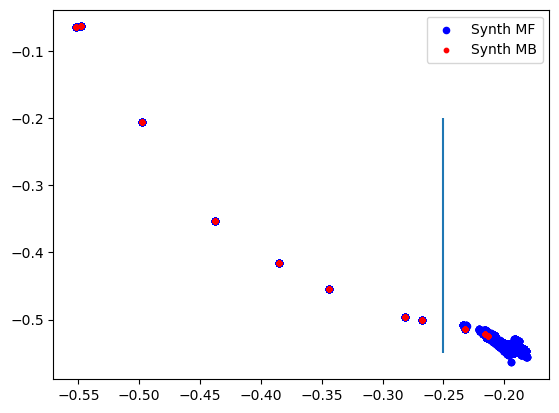

In [11]:
X_embedded_mse = torch.squeeze(model(torch.unsqueeze(torch.from_numpy(np.load(X_fname)).float(), 1))).detach().numpy()
print(X_embedded_mse.shape)

plt.figure()
mse_boundary = 24945

mf = plt.scatter(X_embedded_mse[:mse_boundary, 0], X_embedded_mse[:mse_boundary, 1], color='blue', s=20)
mb = plt.scatter(X_embedded_mse[mse_boundary:, 0], X_embedded_mse[mse_boundary:, 1], color='red', s=10)

plt.legend((mf, mb), ('Synth MF', 'Synth MB'), loc='upper right')

border = -0.25
plt.vlines(border, -.55, -.2)

plt.show()

In [ ]:

print("% of MF that are over:", np.sum(X_embedded_mse[:mse_boundary, 1] > border) / X_embedded_mse[:mse_boundary, 1].size)
print("% of MB that are under:", np.sum(X_embedded_mse[mse_boundary:, 1] < border) / X_embedded_mse[mse_boundary:, 1].size)

print("% of over that are MF:",np.sum(X_embedded_mse[:mse_boundary, 1] > border) / np.sum(X_embedded_mse[:, 1] > border))
print("% of under that are MB:",np.sum(X_embedded_mse[mse_boundary:, 1] < border) / np.sum(X_embedded_mse[:, 1] < border))



1.0 prew

In [ ]:
X_embedded_mse = torch.squeeze(model(torch.unsqueeze(torch.from_numpy(np.load(X_fname)).float(), 1))).detach().numpy()
print(X_embedded_mse.shape)

plt.figure()
mse_boundary = 42171

# X_embedded_mse = normalize_features(X_embedded_mse)

mf = plt.scatter(X_embedded_mse[:mse_boundary, 0], X_embedded_mse[:mse_boundary, 1], color='blue', s=20)
mb = plt.scatter(X_embedded_mse[mse_boundary:, 0], X_embedded_mse[mse_boundary:, 1], color='red', s=10)
# real = plt.scatter(X_embedded_mse[mse_boundary1:, 0], X_embedded_mse[mse_boundary1:, 1], color='yellow', s=5)

borders = [-0.585, -0.57, -0.555, -0.51, -0.45, -0.35, -0.277]
plt.legend((mf, mb), ('Synth MF', 'Synth MB'), loc='upper right')
plt.vlines(borders, -0.6, 0, color='black')

plt.show()

In [ ]:
print("% of MF that are left:", np.sum(X_embedded_mse[:mse_boundary, 0] < border) / X_embedded_mse[:mse_boundary, 0].size)
print("% of MB that are right:", np.sum(X_embedded_mse[mse_boundary:, 0] > border) / X_embedded_mse[mse_boundary:, 0].size)

print("% of left that are MF:",np.sum(X_embedded_mse[:mse_boundary, 0] < border) / np.sum(X_embedded_mse[:, 0] < border))
print("% of right that are MB:",np.sum(X_embedded_mse[mse_boundary:, 0] > border) / np.sum(X_embedded_mse[:, 0] > border))




In [ ]:
plt.figure()
mse_boundary = 42171

mf = plt.scatter(X_embedded_mse[:mse_boundary, 0], X_embedded_mse[:mse_boundary, 1], color='blue', s=15)
mb = plt.scatter(X_embedded_mse[mse_boundary:, 0], X_embedded_mse[mse_boundary:, 1], color='red', s=10)
# real = plt.scatter(X_embedded_mse[mse_boundary1:, 0], X_embedded_mse[mse_boundary1:, 1], color='yellow', s=5)

plt.legend((mf, mb), ('Synth MF', 'Synth MB'), loc='upper right')

plt.show()